In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

ANN, CNN and SVM, to make prediction on hotel

In [2]:
hotel_booking_1 = pd.read_csv("H1.csv"); hotel_booking_2 = pd.read_csv("H2.csv")
df = pd.concat([hotel_booking_1, hotel_booking_2], axis=0).reset_index(drop=True)

In [3]:
df.head(2)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0.0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0.0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [4]:
# df.info()

In [5]:
df.duplicated().sum()

31994

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
null_values =100 *(df.isna().sum() /df.shape[0])
null_values = null_values[null_values > 0]
null_values

Children    0.004577
Country     0.517186
dtype: float64

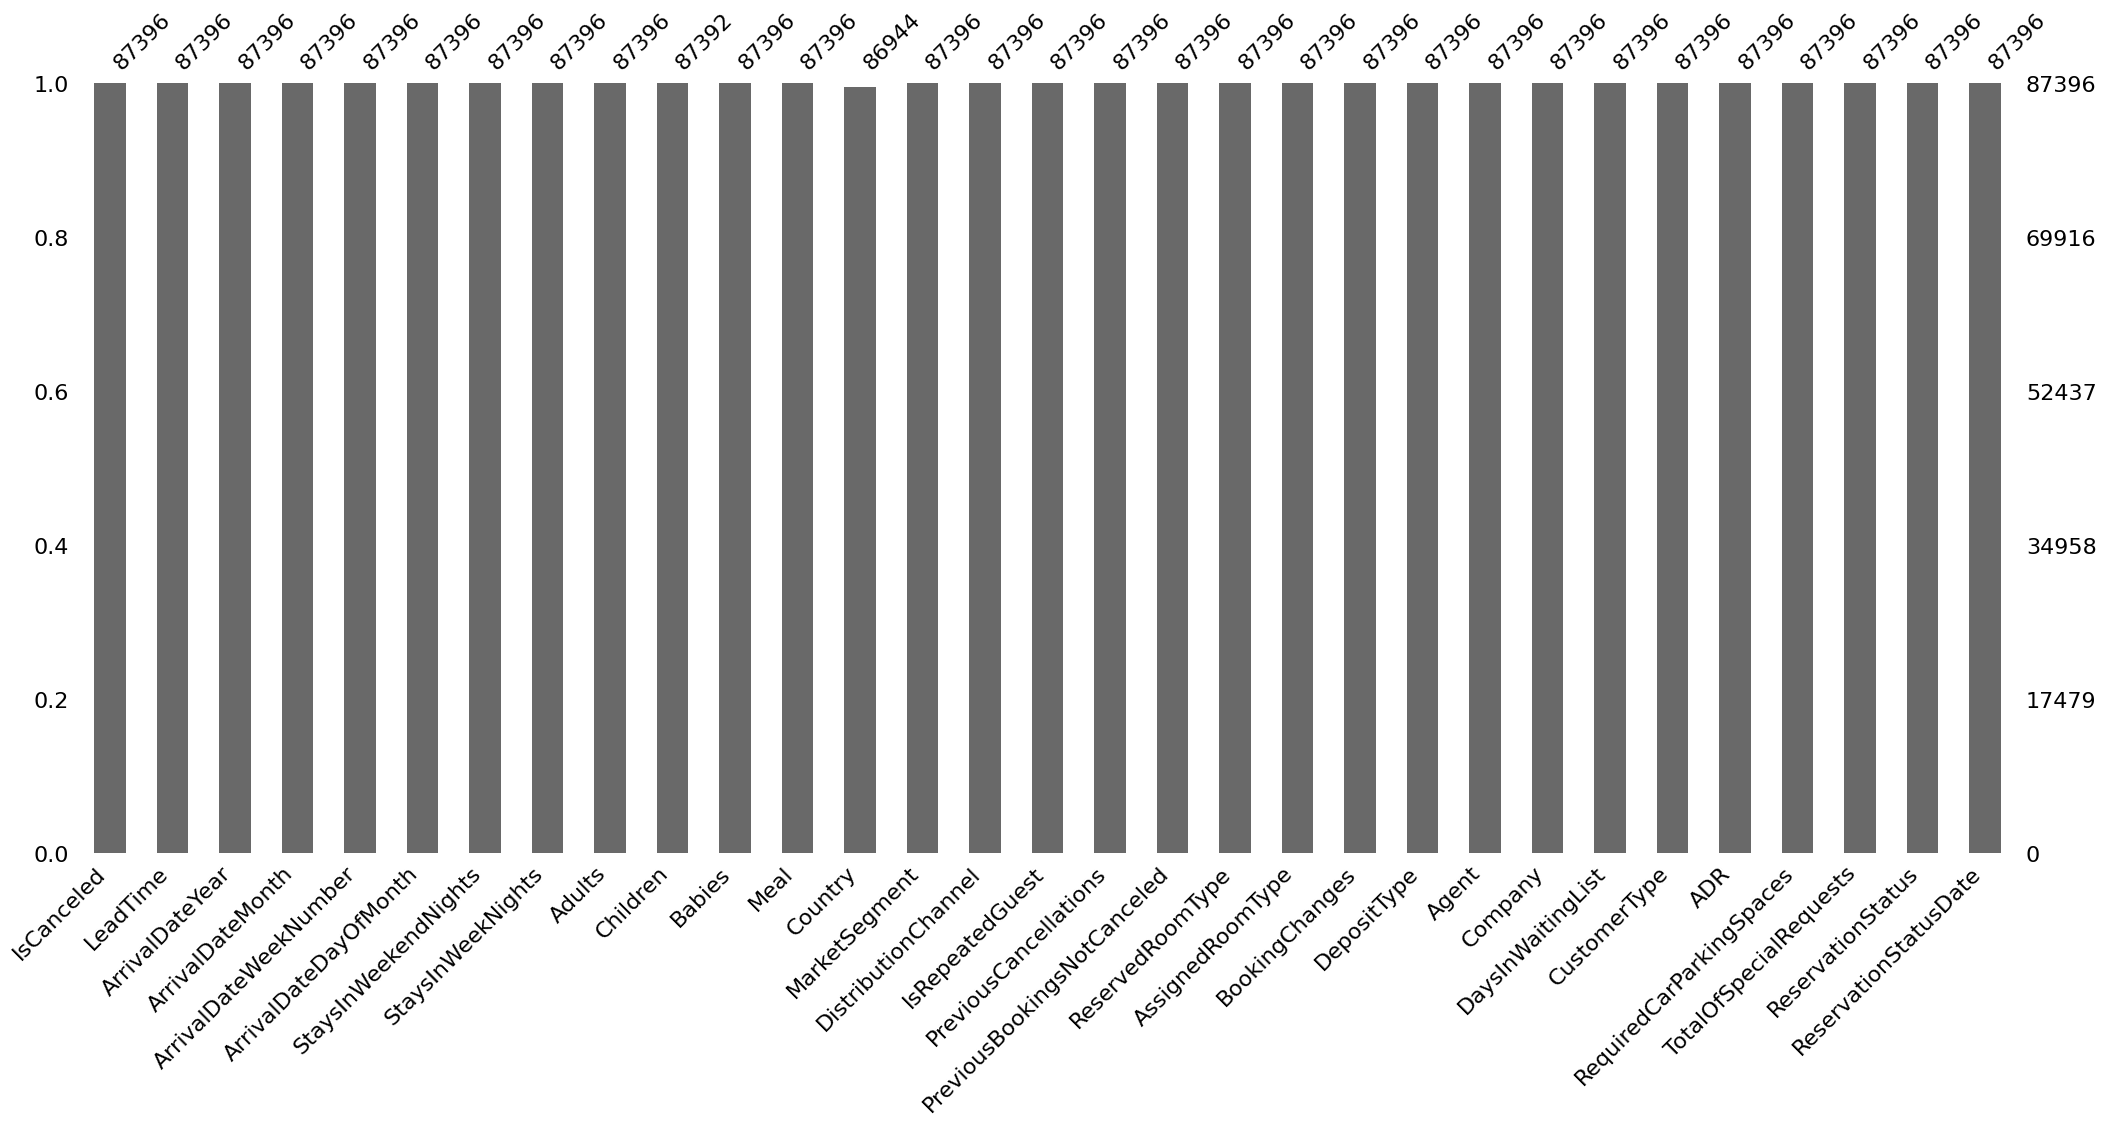

In [8]:
msno.bar(df)
plt.show()

In [9]:
# To check the dataset balance
df['IsCanceled'].value_counts()

IsCanceled
0    63371
1    24025
Name: count, dtype: int64

In [10]:
df['Children'].unique(), df['Babies'].unique(), df['Adults'].unique()

(array([ 0.,  1.,  2., 10.,  3., nan]),
 array([ 0,  1,  2, 10,  9], dtype=int64),
 array([ 2,  1,  3,  4, 40, 26, 50, 27, 55,  0, 20,  6,  5, 10],
       dtype=int64))

In [11]:
# Removing records having 0 occupant
filter = (df.Children == 0) & (df.Adults == 0) & (df.Babies == 0)
df[filter]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
2224,0,1,2015,October,41,6,0,3,0,0.0,...,No Deposit,NULL,174,0,Transient-Party,0.00,0,0,Check-Out,2015-10-06
2409,0,0,2015,October,42,12,0,0,0,0.0,...,No Deposit,NULL,174,0,Transient,0.00,0,0,Check-Out,2015-10-12
3181,0,36,2015,November,47,20,1,2,0,0.0,...,No Deposit,38,NULL,0,Transient-Party,0.00,0,0,Check-Out,2015-11-23
3684,0,165,2015,December,53,30,1,4,0,0.0,...,No Deposit,308,NULL,122,Transient-Party,0.00,0,0,Check-Out,2016-01-04
3708,0,165,2015,December,53,30,2,4,0,0.0,...,No Deposit,308,NULL,122,Transient-Party,0.00,0,0,Check-Out,2016-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,0,107,2017,June,26,27,0,3,0,0.0,...,No Deposit,7,NULL,0,Transient,100.80,0,0,Check-Out,2017-06-30
115091,0,1,2017,June,26,30,0,1,0,0.0,...,No Deposit,NULL,NULL,0,Transient,0.00,1,1,Check-Out,2017-07-01
116251,0,44,2017,July,28,15,1,1,0,0.0,...,No Deposit,425,NULL,0,Transient,73.80,0,0,Check-Out,2017-07-17
116534,0,2,2017,July,28,15,2,5,0,0.0,...,No Deposit,9,NULL,0,Transient-Party,22.86,0,1,Check-Out,2017-07-22


In [12]:
# removing invalid records
df = df[~filter]
df[filter]

C:\Users\HP\AppData\Local\Temp\ipykernel_20888\2255186753.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[filter]


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate


In [13]:
# df.columns

In [14]:
#From where the most guest are coming, displaying top 10

guest_city = df[df['IsCanceled'] == 0]['Country'].value_counts().reset_index()
guest_city.columns = ['Country', 'No of guests']
guest_city.head(10)

,Country,No of guests
0,PRT,17573
1,GBR,8440
2,FRA,7091
3,ESP,5382
4,DEU,4332
5,IRL,2347
6,ITA,1986
7,BEL,1670
8,NLD,1560
9,USA,1412


In [15]:
#From where the most guest cancel there bookings, displaying top 10

guest_city = df[df['IsCanceled'] == 1]['Country'].value_counts().reset_index()
guest_city.columns = ['Country', 'No of guests']
guest_city.head(10)

,Country,No of guests
0,PRT,9782
1,GBR,1984
2,ESP,1862
3,FRA,1732
4,ITA,1075
5,DEU,1053
6,BRA,727
7,IRL,668
8,USA,459
9,BEL,411


In [16]:
fig = px.choropleth(guest_city, 
                    locations="Country",
                    color="No of guests",
                    hover_name="Country",
                    projection="natural earth",
                    title="Number of Guests by Country")

# Set the height and width of the figure
fig.update_layout(height=600, width=1000)

fig.show()

In [17]:
# Select categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# Select numerical columns
num_columns = df.select_dtypes(include=['number']).columns

cat_columns, num_columns

(Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
        'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
        'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
        'ReservationStatusDate'],
       dtype='object'),
 Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
        'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
        'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
        'PreviousCancellations', 'PreviousBookingsNotCanceled',
        'BookingChanges', 'DaysInWaitingList', 'ADR',
        'RequiredCarParkingSpaces', 'TotalOfSpecialRequests'],
       dtype='object'))

In [19]:
len(cat_columns), len(num_columns)

(13, 18)

In [20]:
# count of uniques values in a column
for i in cat_columns:
    print(i,':',df[i].nunique())

ArrivalDateMonth : 12
Meal : 5
Country : 177
MarketSegment : 8
DistributionChannel : 5
ReservedRoomType : 9
AssignedRoomType : 11
DepositType : 3
Agent : 334
Company : 349
CustomerType : 4
ReservationStatus : 3
ReservationStatusDate : 926


In [21]:
for i in cat_columns:
    print(i,':',df[i].unique())
    print('-----------------------------------')

ArrivalDateMonth : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
-----------------------------------
Meal : ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
-----------------------------------
Country : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'I

In [22]:
df1 = df.copy()

Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
       'ReservationStatusDate'],
      dtype='object')

In [27]:
for i in cat_columns:
    df1[i] = df1[i].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [28]:
for i in cat_columns:
    print(i,':',df1[i].unique())
    print('-----------------------------------')

ArrivalDateMonth : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
-----------------------------------
Meal : ['BB' 'FB' 'HB' 'SC' 'Undefined']
-----------------------------------
Country : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC'

In [30]:
df1['ReservationStatusDate'] = pd.to_datetime(df1['ReservationStatusDate'])
df1['Year'] = df1['ReservationStatusDate'].dt.year
df1['Month'] = df1['ReservationStatusDate'].dt.month
df1['Day'] = df1['ReservationStatusDate'].dt.day
df1.drop(['ArrivalDateMonth', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth','ReservationStatusDate'], axis=1, inplace=True)
print(df1['Year'].unique()); print(df1['Month'].unique()); print(df1['Day'].unique())

[2015 2014 2016 2017]
[ 7  5  4  6  3  8  9  1 11 10 12  2]
[ 1  2  3  6 22 23  5  7  8 11 15 16 29 19 18  9 13  4 12 26 17 10 20 14
 30 28 25 21 27 24 31]


In [31]:
df1['Company'].groupby(df1['Company']).count().sort_values(ascending=False).head(10)

Company
NULL    81993
40        848
223       503
45        237
153       205
154       133
219       131
281       119
174       119
233        94
Name: Company, dtype: int64

We decided to drop the company columns since multiple records have NULL value

In [32]:
df1.drop(['Company'], axis=1, inplace=True)

In [33]:
df1['Meal'].groupby(df1['Meal']).count().sort_values(ascending=False).head(10)

Meal
BB           67907
SC            9391
HB            9080
Undefined      492
FB             360
Name: Meal, dtype: int64

In [35]:
df1[df1['Meal'] == 'Undefined'].groupby('IsCanceled').size()

IsCanceled
0    410
1     82
dtype: int64

In [34]:
df1['Agent'].groupby(df1['Agent']).count().sort_values(ascending=False).head(10)

Agent
9       28721
240     13028
NULL    12141
14       3342
7        3294
250      2779
241      1644
28       1493
8        1383
1        1228
Name: Agent, dtype: int64

In [36]:
df1[df1['Agent'] == 'NULL'].groupby('IsCanceled').size()

IsCanceled
0    10593
1     1548
dtype: int64

In [37]:
df1.drop(['Agent','Meal'], axis=1, inplace=True)

In [38]:
df1.columns

Index(['IsCanceled', 'LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'Country', 'MarketSegment',
       'DistributionChannel', 'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'DaysInWaitingList', 'CustomerType',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ReservationStatus', 'Year', 'Month', 'Day'],
      dtype='object')

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87230 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   87230 non-null  int64  
 1   LeadTime                     87230 non-null  int64  
 2   StaysInWeekendNights         87230 non-null  int64  
 3   StaysInWeekNights            87230 non-null  int64  
 4   Adults                       87230 non-null  int64  
 5   Children                     87226 non-null  float64
 6   Babies                       87230 non-null  int64  
 7   Country                      86783 non-null  object 
 8   MarketSegment                87230 non-null  object 
 9   DistributionChannel          87230 non-null  object 
 10  IsRepeatedGuest              87230 non-null  int64  
 11  PreviousCancellations        87230 non-null  int64  
 12  PreviousBookingsNotCanceled  87230 non-null  int64  
 13  ReservedRoomType    

In [40]:
# Select categorical columns
cat_columns = df1.select_dtypes(include=['object']).columns

# Select numerical columns
num_columns = df1.select_dtypes(include=['number']).columns

cat_columns, num_columns

(Index(['Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
        'AssignedRoomType', 'DepositType', 'CustomerType', 'ReservationStatus'],
       dtype='object'),
 Index(['IsCanceled', 'LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
        'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
        'PreviousCancellations', 'PreviousBookingsNotCanceled',
        'BookingChanges', 'DaysInWaitingList', 'ADR',
        'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'Year', 'Month',
        'Day'],
       dtype='object'))

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

In [42]:
X = df1.drop(columns=['IsCanceled'])  # Features
y = df1['IsCanceled'] 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69784, 25), (17446, 25), (69784,), (17446,))

In [62]:
X_train.columns
X_train.head(2)

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,...,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,Year,Month,Day
63965,25,1,1,3,0.0,0,NLD,Online TA,TA/TO,0,...,No Deposit,0,Transient,158.0,0,0,Canceled,2017,2,16
95105,65,1,2,2,0.0,0,FRA,Offline TA/TO,TA/TO,0,...,No Deposit,0,Transient,85.0,0,1,Check-Out,2016,8,15


In [53]:
# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [54]:
# Define the ANN model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)

# Create pipeline including preprocessing and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', mlp)])

In [55]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWa...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'AssignedRoomType', 'DepositType', 'CustomerType', 'ReservationStatus'],
      dtype='object'))])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000))])

In [70]:
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)
accuracy = pipeline.score(X_train, y_train)
print("Train Accuracy:", accuracy)

Test Accuracy: 1.0
Train Accuracy: 1.0


In [69]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression model
logistic_model = LogisticRegression()

# Create pipeline including preprocessing and logistic regression model
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

# Train the logistic regression model
logistic_pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = logistic_pipeline.score(X_train, y_train)
print("Train Accuracy:", accuracy)

# Evaluate the model
accuracy = logistic_pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Train Accuracy: 1.0
Test Accuracy: 1.0


In [74]:
from sklearn.svm import SVC

# Define SVM model
svm_model = SVC(kernel='rbf',probability=True)  # You can adjust kernel and other parameters as needed

# Create pipeline including preprocessing and SVM model
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

# Train the SVM model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_pipeline.score(X_train, y_train)
print("Train Accuracy:", accuracy)

# Evaluate the model
accuracy = svm_pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)


Train Accuracy: 0.9998137108792846
Test Accuracy: 0.9993121632465894


Accuracy: 0.9993121632465894
Precision: 1.0
Recall: 0.9974565493853328
F1 Score: 0.9987266553480475


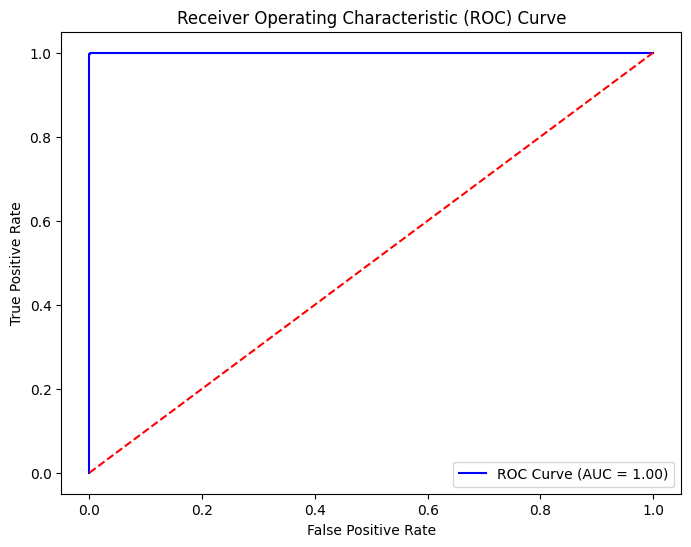

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_pred = svm_pipeline.predict(X_test) 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot ROC curve
try:
    y_pred_proba = svm_pipeline.predict_proba(X_test)[:, 1]  # Change to logistic_pipeline if using logistic regression
except AttributeError:
    print("Predict_proba is not available for the SVM pipeline. Using decision function instead.")
    y_pred_proba = svm_pipeline.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()